In [32]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from scipy.stats.mstats import zscore
from sklearn.metrics import f1_score



In [2]:
matrices = pd.read_pickle('/home/nick/Desktop/dki_stuff/masked_matrices.pickle')
matrices

,cons,pats
dmean,"[[0.900367, 0.929843, 0.892926, 0.920383, 0.87...","[[0.947932, 0.997482, 0.966199, 0.994236, 0.93..."
fa,"[[0.193831, 0.233026, 0.21176, 0.266958, 0.191...","[[0.159587, 0.201227, 0.169772, 0.196879, 0.16..."
kmean,"[[0.890155, 0.896358, 0.915954, 0.90995, 0.946...","[[0.907448, 0.916198, 0.943497, 0.947185, 0.92..."


In [58]:
X = np.vstack((matrices.ix['dmean']))
y_len = map(len,matrices.ix['dmean'])
n_samples = np.sum(y_len)
print n_samples

y = np.vstack((np.array([0] * y_len[0]).reshape((-1,1)),np.array([1] * y_len[1]).reshape((-1,1)))).reshape(n_samples)
y

68


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
for col in xrange(X.shape[1]):
    X[:,col] = zscore(X[:,col]) 
    X[:,col] = X[:,col] / np.sqrt( sum( [ x**2 for x in X[:,col] ] ) )

In [59]:
alpha_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,10]
gamma_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,10]

score_matrix = np.zeros((6,len(alpha_range),len(gamma_range)))

def MakeBinary(w):
    w[w > 0] = 1
    w[w <= 0 ] = 0
    return w

cv = StratifiedKFold(y,6)

fold = 0
for train, val in cv:
    y_val = y[val]
    X_val = X[val]
    
    y_train = y[train]
    X_train = X[train]
    for alpha_it, alpha in enumerate(alpha_range):
        ls = Lasso(alpha,copy_X=True)
        ls.fit(X_train,y_train)
        w = MakeBinary(ls.coef_)
        np.nonzero(w)
        print '{} features selected @ alpha : {}'.format(np.count_nonzero(w),alpha)

        X_train_w = X_train * w
        X_val_w = X_val * w 

        for gamma_it ,gamma in enumerate(gamma_range):
            svc = SVC(gamma = gamma)
            svc.fit(X_train_w,y_train)
            y_val_pred = svc.predict( X_val_w )
            score = f1_score( y_val , y_val_pred )
            score_matrix[ fold, alpha_it, gamma_it ] = score
            print '| fold : {:>6} | alpha : {:>6} | gamma : {:>6} |  score : {:>5} % '.format(fold,alpha,gamma,round(score*100,2))

    fold += 1

   



(array([     0,      1,      2, ..., 402556, 422781, 425236]),)
2260 features selected @ alpha : 1e-06


KeyError: '>'

Populating the interactive namespace from numpy and matplotlib


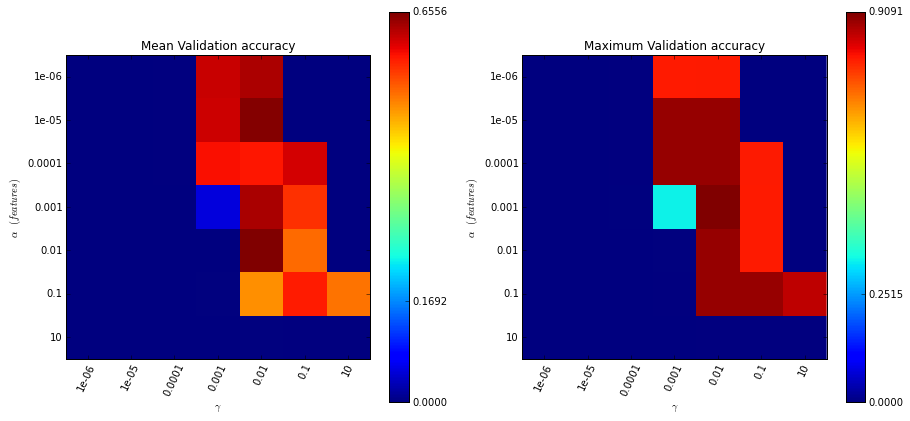

In [48]:
%pylab inline
plt.figure(figsize=(15,7))
plt.subplot(121)
mean_scores = np.mean(score_matrix,axis=0)
cax = imshow(mean_scores,interpolation='none')
cbar = plt.colorbar(cax, ticks=[np.min(mean_scores), np.mean(mean_scores), np.max(mean_scores)])
plt.xticks(np.arange(len(gamma_range)),gamma_range, rotation=65)
plt.yticks(np.arange(len(alpha_range)),alpha_range)
plt.ylabel(r'$\alpha\;(features)$')
plt.title('Mean Validation accuracy')
plt.xlabel(r'$\gamma$')
plt.subplot(122)
max_scores = np.max(score_matrix,axis=0)
cax = imshow(max_scores,interpolation='none')
cbar = plt.colorbar(cax, ticks=[np.min(max_scores), np.mean(max_scores), np.max(max_scores)])
plt.xticks(np.arange(len(gamma_range)),gamma_range, rotation=65)
plt.yticks(np.arange(len(alpha_range)),alpha_range)
plt.ylabel(r'$\alpha\;(features)$')
plt.title('Maximum Validation accuracy')
plt.xlabel(r'$\gamma$')
# for i,a in enumerate(alpha_range):
#     d = data_frame[data_frame.alpha == a]
#     for j,g in enumerate(gam):
#         try:
#             sc_ = np.float(d[d.gamma == g]['results_mean'])
#         except:
#             sc_ = -1
#         if np.max(scores) - sc_ < .05:
#             w = 'normal'
#             if sc_ == np.max(scores):
#                 w = 'semibold'
#             ax.annotate(str(np.round(sc_,2))[1:], xy=(j, i),weight=w, horizontalalignment='center', verticalalignment='center')


(7, 7)
(7, 7)
(7, 7)


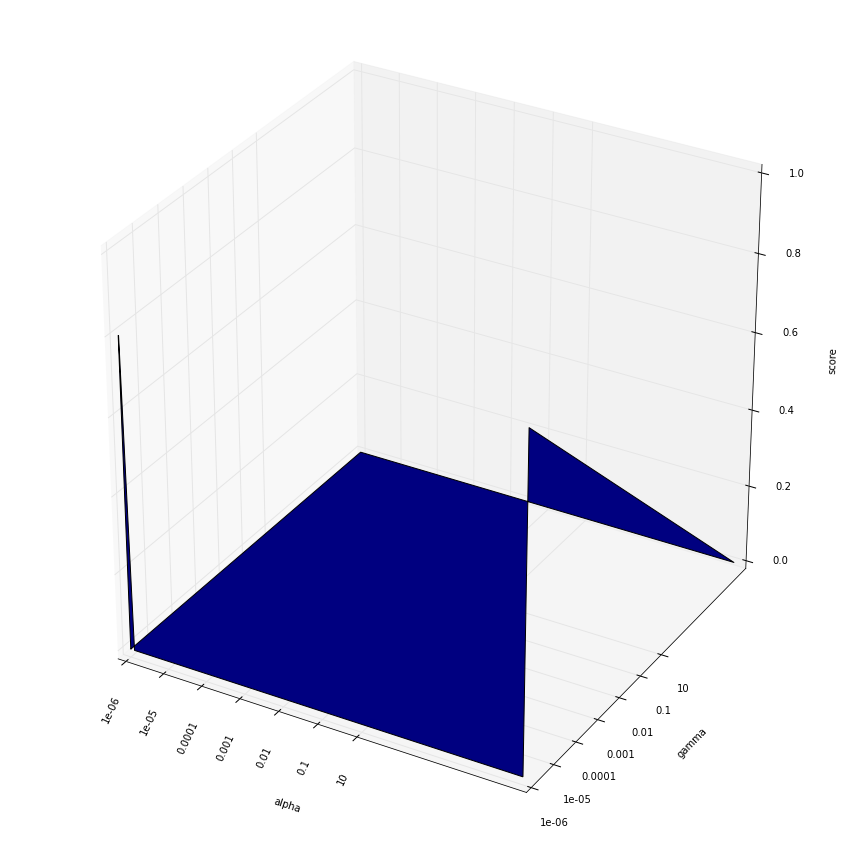

In [54]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
x = y =np.array(gamma_range)
X, Y = np.meshgrid(x, y)
zs = np.max(score_matrix,axis=0)
Z = zs.reshape(X.shape)
print X.shape
print Y.shape
print Z.shape

ax.plot_surface(X, Y, Z)
plt.xticks(np.arange(len(gamma_range)),gamma_range, rotation=65)
plt.yticks(np.arange(len(alpha_range)),alpha_range)
ax.set_xlabel('alpha')
ax.set_ylabel('gamma')
ax.set_zlabel('score')

plt.show()

In [ ]:
# visualize voxels

In [69]:

score_matrix = np.zeros((6,len(alpha_range),len(gamma_range)))

cv = StratifiedKFold(y,6)
selected_voxels = []
for train, val in cv:
    y_val = y[val]
    X_val = X[val]
    
    y_train = y[train]
    X_train = X[train]

    ls = Lasso(.01,copy_X=True)
    ls.fit(X_train,y_train)
    w = MakeBinary(ls.coef_)
    selected_voxels.append(np.nonzero(w))


In [74]:
s = set([num for l in selected_voxels for num in l])
count_map = dict()
for i in s:
    count = selected_voxels.count(i)
    count_map[i] = count
    
count_map

AttributeError: 'list' object has no attribute 'tolist'